<a href="https://colab.research.google.com/github/CelikAbdullah/deep-learning-notebooks/blob/main/Deep%20Reinforcement%20Learning/Value%20Based/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import time
from matplotlib import pyplot as plt
from itertools import count
import tempfile
import os
import imageio
from PIL import Image
import PIL.ImageDraw as ImageDraw

# Q Network

In this section, we create a fully connected neural network which will approximate the Q function. Given a batch of states as input, it outputs a batch of Q-values. Each Q-value represents the return we can expect when we take a particular action in the given state.

In [ ]:
class QNetwork(nn.Module):
  def __init__(self,
               input_dim,
               output_dim,
               hidden_dims=(32,32),
               activation_fc=F.relu):
    super(QNetwork, self).__init__()
    self.activation_fc = activation_fc
    self.input_layer = nn.Linear(input_dim, hidden_dims[0])

    self.hidden_layers = nn.ModuleList()
    for i in range(len(hidden_dims)-1):
      hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
      self.hidden_layers.append(hidden_layer)

    self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda:0"
    self.device = torch.device(device)
    self.to(self.device)

  def _format(self, state):
    x = state
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, device=self.device, dtype=torch.float32)
      x = x.unsqueeze(0)

    return x

  def forward(self, state):
    x = self._format(state)
    x = self.activation_fc(self.input_layer(x))
    for hidden_layer in self.hidden_layers:
      x = self.activation_fc(hidden_layer(x))

    x = self.output_layer(x)
    return x

  def numpy_float_to_device(self, variable):
    variable = torch.from_numpy(variable).float().to(self.device)
    return variable

  def load(self, experiences):
    states, actions, rewards, new_states, is_terminals = experiences
    states = torch.from_numpy(states).float().to(self.device)
    actions = torch.from_numpy(actions).long().to(self.device)
    new_states = torch.from_numpy(new_states).float().to(self.device)
    rewards = torch.from_numpy(rewards).float().to(self.device)
    is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
    return states, actions, rewards, new_states, is_terminals

# Replay Buffer

The replay buffer is a data structure that allows us to implement a technique called **experience replay**. It holds experience samples for several timesteps so that we can sample mini-batches of experiences.

The main benefit of using a replay buffer: the samples (experiences) we pass to the network appear independent and identically distributed which in turn stabilize the optimization process.

The idea behind experience replay is very straightforward:
During training, we collect experiences and store them into the replay buffer. After enough experiences are collected, we then sample a mini-batch of a certain size from the buffer and pass it to the network.

In [ ]:
class ReplayBuffer():
  # our replay buffer has a default max size of 50000 and uses a batch size of 64
  def __init__(self, max_size=10000,
               batch_size=64):

    # initialize five empty NumPy arrays that will hold states, actions, rewards, next_states and done flags
    self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)

    self.max_size = max_size
    self.batch_size = batch_size
    self._idx = 0
    self.size = 0

  def store(self, experience):
    '''
    Store the components of the experience into the corresponding NumPy array.
    '''
    # unwrap the experience which is just a tuple
    s, a, r, p, d = experience

    # store each component to its corresponding NumPy array
    self.ss_mem[self._idx] = s
    self.as_mem[self._idx] = a
    self.rs_mem[self._idx] = r
    self.ps_mem[self._idx] = p
    self.ds_mem[self._idx] = d

    # adjust the index
    self._idx += 1

    # if the replay buffer is full, we wrap around and overwrite older experiences with new ones
    self._idx = self._idx % self.max_size

    # adjust the size
    self.size += 1
    # determine the size
    self.size = min(self.size, self.max_size)

  def sample(self, batch_size=None):
    '''
    Sample a mini-batch of experiences from the replay buffer.
    '''
    if batch_size == None:
      batch_size = self.batch_size

    # Generate a uniform random sample from np.arange(self.size) of size 'batch_size' without replacement:
    idxs = np.random.choice(self.size, batch_size, replace=False)

    # create the mini-batch of experiences
    mini_batch_experiences = np.vstack(self.ss_mem[idxs]), \
                             np.vstack(self.as_mem[idxs]), \
                             np.vstack(self.rs_mem[idxs]), \
                             np.vstack(self.ps_mem[idxs]), \
                             np.vstack(self.ds_mem[idxs])

    return mini_batch_experiences

  def __len__(self):
    return self.size

The first NumPy method we use in the ReplayBuffer class is the **random.choice(a, size=None, replace=True, p=None)** method. The NumPy tells that it creates a random sample from a given 1-D array.

In our case, we will use it to produce a list of random values representing indices. Those indices will then be used to select states, actions, rewards, etc. from the replay buffer. That's it.

Here, are some examples:

In [ ]:
# Generate a uniform random sample from np.arange(5) of size 4 without replacement
# Basically, what happens is that it selects values randomly between 0 and 5; and it does it 4 times; there are no duplicates
idxs = np.random.choice(6, 4, replace=False)
idxs

array([2, 5, 0, 1])

As you can see, we obtained an array of values between 0 and 5. We would then later use those values as index to grab the corresponding rewards from the rs_mem array, for example.
Imagine our rewards array rs_mem contains the following values:

In [ ]:
rs_mem = np.array([-10, 21, 45, 4, 9, 6, 150])

Then indexing via idx into the rs_mem array would give us the following:

In [ ]:
rs_mem[idxs]

array([ 45,   6, -10,  21])

The other Numpy method we use in the ReplayBuffer class is **np.vstack**. As the name implies, this method stacks arrays in sequence vertically (row wise). It gets a sequence of ndarrays and returns a stacked ndarray which is an array formed by stacking the given ndarrays. To put it simply, what happens is that it puts all given ndarrays on top of each other.

For example, when **np.vstack(self.rs_mem[idxs])** is called, the ndarrays coming from **self.rs_mem[idxs]** (see above) are stacked in sequence vertically.

In the following, you can see a better example. We first create a replay buffer with 5 experiences and then invoke the sample() method which contains the np.vstack() method:

In [ ]:
env = gym.make("CartPole-v1")
replay_buffer = ReplayBuffer(batch_size=5)
state = env.reset()
for _ in range(5):
  action = np.random.randint(2)
  next_state, reward, is_terminal, info = env.step(action)
  experience = (state, action, next_state, reward, is_terminal)
  replay_buffer.store(experience)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
replay_buffer.sample()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([[-0.01094035,  0.03903606, -0.02748079, -0.01445623],
        [-0.01094035,  0.03903606, -0.02748079, -0.01445623],
        [-0.01094035,  0.03903606, -0.02748079, -0.01445623],
        [-0.01094035,  0.03903606, -0.02748079, -0.01445623],
        [-0.01094035,  0.03903606, -0.02748079, -0.01445623]],
       dtype=float32),
 array([[1],
        [0],
        [0],
        [0],
        [0]]),
 array([[-0.02028117, -0.15496711, -0.01131674,  0.2535779 ],
        [-0.02338051, -0.34992567, -0.00624518,  0.54266995],
        [-0.01015962, -0.15568122, -0.02776991,  0.26943108],
        [-0.01327325, -0.3503961 , -0.02238129,  0.5532275 ],
        [-0.03037903, -0.5449593 ,  0.00460821,  0.8333786 ]],
       dtype=float32),
 array([[1.],
        [1.],
        [1.],
        [1.],
        [1.]]),
 array([[False],
        [False],
        [False],
        [False],
        [False]]))

# Exploration strategies

The GreedyStrategy will always select the maximum Q-value.

In [ ]:
# the strategy we will use in the evaluation phase
class GreedyStrategy():
  def __init__(self):
    self.exploratory_action_taken = False

  def select_action(self, model, state):
    with torch.no_grad():
      # get the q-value of each action given the state
      q_values = model(state).cpu().detach().data.numpy().squeeze()

      # return the index of the action with the highest estimate
      return np.argmax(q_values)

The exponential $\epsilon$-greedy strategy a decaying epsilon value so that the probability of exploration is higher at the beginning and the probability of exploitation is higher at the end of the training phase.

In [ ]:
# the strategy we will use in the training phase
class EGreedyExpStrategy():
  '''
  In the exponentially decaying strategy, the epsilon value is decaying in an exponential curve.
  '''

  def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
    self.epsilon = init_epsilon
    self.init_epsilon = init_epsilon
    self.decay_steps = decay_steps
    self.min_epsilon = min_epsilon
    self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
    self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
    self.t = 0

  def _epsilon_update(self):
    self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
    self.t += 1

    return self.epsilon

  def select_action(self, model, state):
    self.exploratory_action_taken = False
    with torch.no_grad():
      q_values = model(state).detach().cpu().data.numpy().squeeze()

    # we draw the random number from a uniform distribution and compare it to epsilon
    # if it is higher, we use the argmax of the q-values
    # otherwise, we use a random action
    if np.random.rand() > self.epsilon:
      action = np.argmax(q_values)
    else:
      action = np.random.randint(len(q_values))

    # adjust the epsilon value
    self._epsilon_update()

    return action

# Deep Q-Network (DQN)

In the following, we will discuss the DQN algorithm step-by-step:


1.   Get an initial state $s$ from the environment
2.   Pass the initial state $s$ to the online network
     which outputs a Q-value for each action
3.   Pass the Q-values to our training strategy which selects an action $a$
4.   Take that action $a$ in the environment. As a result, we obtain the next state $s'$, a reward $r$ and a flag $d$ indicating whether a terminal state is reached or not
5.   Build an experience tuple $(s, a, s', r, d)$ and store it into a replay buffer $D$
6.   If $D$ has not a minimum number of experiences, repeat the steps 2.-5. with the next state $s'$
7.   Otherwise, sample a mini-batch of experiences from the replay buffer $D$
8.   Extract the mini-batch to obtain a batch of states $S$, actions $A$, next states $S'$, rewards $R$ and terminal flags $D$
9.   Pass $S$  into the online network which outputs a batch of Q-values $Q$
10.  Use $A$ to select the right Q-values from $Q$; these Q-values will be our predictions $P$
11.  Pass $S'$ to the target network to obtain a batch of Q-values $Q'$
12.  Select only the maximum Q-values from $Q'$; let's call that subset $maxQ$ and multiply them with $(1-D)$
13.  Use $R$ and a discount factor $\gamma$ to build the target Q-values $T$ as follows: $ T = R + \gamma \max Q$
14.  Pass the predictions $P$ and the targets $T$ to the loss function and perform optimization
15.  Update the target network after every $n$ steps




## Interact with the environment

At this step, we interact with the environment by taking a selected **action** within the environment. The action is selected based on our chosen training strategy (in this case: **EGreedyExpStrategy**). The resulting infos such as **new_state**, **reward**, etc. will then be used to form an experience.

Finally, that **experience** is then stored into the **replay buffer**. At the end, we also make updates to global variables (but those are not relevant for understanding the DQN algorithm; those are just for the statistics). And that's it.

In [ ]:
# interact with the environment
def interaction_step(state, env):
  # select an action
  action = training_strategy.select_action(online_model, state)
  # take the selected action
  new_state, reward, is_terminal, info = env.step(action)

  # check TimeLimit of the CartPole environment
  is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
  is_failure = is_terminal and not is_truncated

  # create the experience as tuple
  experience = (state, action, reward, new_state, float(is_failure))

  # store the experience into the replay buffer
  replay_buffer.store(experience)

  # keep track of the timestep so that we know when to update the target network's weights
  episode_timestep[-1] += 1

  # return new state & the is_terminal flag to caller
  return new_state, is_terminal


## Optimize the network

At this step, we optimize the model using the following formula:

$\nabla_{\theta_{i}} L_{i} (\theta_{i}) = \mathbb{E}_{\underbrace{(s, a, r, s') \sim U(D)}_\text{sampling of experiences}}[ \underbrace{(r + \gamma \max_{a'} Q(s', a'; \theta^-)}_\text{Target} - \underbrace{Q(s, a; \theta_{i})}_\text{Prediction}) \nabla_{\theta_{i}}Q(s, a; \theta_{i})]$

Here are the components of the formula:

*   $\mathbb{E}_{(s, a, r, s') \sim U(D)}$

    we use the expectations of the experience tuples; we obtain the experiences we use for training by sampling uniformly at random the replay buffer D
*   $r$

    the experienced reward we get when we take a particular action $a$ in state $s$
*   $\gamma \max_{a'} Q(s', a'; \theta^-)$

    The discount factor $\gamma$ is used to discount the value of the action $a'$ with the highest estimate at the next state $s'$
    $\theta^-$ indicates that the target network will be used to query the Q-value estimates of the next state $s'$; after obtaining those, we select the maximum Q-value estimate

*   $r + \gamma \max_{a'} Q(s', a'; \theta^-)$

    This forms the Q-value target, also referred to as the off-policy TD target.
    In RL, there no are no real "true" values we could use as targets like in supervised learning. Therefore, our targets are predicted values themselves because they come from a network (in this case, from a target network)

*   $Q(s, a; \theta_{i})$

    This part forms the Q-value predictions; we pass the current state to the online network and get the Q-values estimates for each action $a$ in the state $s$

*   $\nabla_{\theta_{i}}Q(s, a; \theta_{i})$

    Indicates that we should apply backpropagation only to the online network $\theta_{i}$ during the training the training process.


In [ ]:
def optimize(experiences):

  # extract the experience components
  states, actions, rewards, next_states, is_terminals = experiences
  batch_size = len(is_terminals)

  # looking at those estimates, select only the max Q-values
  max_q_values = target_model(next_states).detach().max(dim=1)[0].unsqueeze(1)

  # now, we can build the target_q_values
  target_q_values = rewards + (gamma * max_q_values * (1 - is_terminals))

  # since we are only interested in the Q-values of those actions
  # that were actually taken, we gather them by using the values
  # from the actions batch as index
  predicted_q_values = online_model(states).gather(1, actions)

  # compute the loss
  loss = (predicted_q_values - target_q_values).pow(2).mul(0.5).mean()

  # zero out the gradients
  optimizer.zero_grad()
  # apply backpropagation
  loss.backward()
  # store the loss (only for visualization)
  losses.append(loss.item())
  # update the weights
  optimizer.step()

In the optimize() method we use two PyTorch functions: max() and gather(). In the following, we will discuss these two a little bit for a better understanding of the code.

Let's imagine that we have the following batch of Q values the model has given us after a forward pass:

In [ ]:
q_vals_batch = torch.randn(4,4)
q_vals_batch

tensor([[-1.3822,  0.8268, -1.4039,  0.4025],
        [ 0.5191,  0.2619,  0.0527, -2.7611],
        [ 0.0870, -0.1706, -0.7009,  1.2670],
        [ 1.2367,  0.1418, -0.4128,  0.7652]])

Now, when we call **q_values_batch.max(dim=1)**, then (according to the documentation) it will return a namedtuple (**values**, **indices**) where

*   **values** is the maximum value of each row of the input tensor in given dimension **dim**
*   **indices** is the index location of each maximum value found (argmax).

In [ ]:
q_vals_batch.max(dim=1)

torch.return_types.max(
values=tensor([0.8268, 0.5191, 1.2670, 1.2367]),
indices=tensor([1, 0, 3, 0]))

For now, let's just focus on the values component. It is a tensor containing the max values from each row. For example, looking at the input tensor, we can verify that max selects the maximum value of each row along the first dimension.

To extract only the **values** component of the returned name tuple, we then use the index operator [] on the resulting tuple as follows:

In [ ]:
max_q_vals = q_vals_batch.max(dim=1)[0]
max_q_vals

tensor([0.8268, 0.5191, 1.2670, 1.2367])

Since we operate with batches, we add a dimension using the PyTorch method unsqueeze():

In [ ]:
max_q_vals = q_vals_batch.max(dim=1)[0].unsqueeze(1)
max_q_vals

tensor([[0.8268],
        [0.5191],
        [1.2670],
        [1.2367]])

The second PyTorch method we use in the optimize_model() method is the **gather(input, dim, index, *, sparse_grad=False, out=None)** method. As the name implies, it gathers values along an axis specified by dim.

In our case, the input tensor contains the batch of Q values predicted by the model given a batch of states. So, for each state in the 'states' batch, we obtain an array that contains the Q-value estimate for a particular action in that state.
We use gather() because we are only interested in the Q-value estimates of those actions that were actually taken. Therefore, we gather the Q-values along dim=1 using the 'actions' batch as the index parameter. In other words, the 'actions' batch tells the gather() method exactly which action was taken by the agent so that gather() can select the corresponding Q-value for us.

Let's create a simple example to understand it better. Imagine we have the following batch of predicted Q-values that came from a network:

In [ ]:
# let's say that we have 4 states in our mini-batch and 3 actions are possible in the environment.
q_values = torch.randn(4,3)

# the Q-value estimates for each action would then be the following:
q_values

tensor([[ 0.8338,  0.7857,  0.7887],
        [-0.4898, -0.7486,  0.6661],
        [-1.6632,  0.3243,  0.2933],
        [ 1.2260, -1.0111, -0.3374]])

As mentioned, we are not interested in all Q-values for each action; only the Q-values of the actions that were actually taken are of interest. Let's say that our actions batch looks like:

In [ ]:
actions = torch.tensor((2, 0, 1,2)).unsqueeze(1)
actions

tensor([[2],
        [0],
        [1],
        [2]])

Since actions contain the indices of the actions that were taken by the agent, we can tell that it selected the action 2 in the first state, the action 0 in the second state, the action 1 in the
third state and action 2 in the fourth state.

Giving the actions batch to the gather() method as the argument for the index parameter, we can retrieve the Q-values of those actions:

In [ ]:
q_values_of_taken_actions = q_values.gather(dim=1, index=actions)
q_values_of_taken_actions

tensor([[ 0.7887],
        [-0.4898],
        [ 0.3243],
        [-0.3374]])

## Update the target network

The update() method is responsible for updating the weights of the target network with the weights of the online network.

In [ ]:
def update_network(online_model, target_model):
  # iterate through all the weights of the online network and copy them to the target network
  for target, online in zip(target_model.parameters(),
                            online_model.parameters()):
    target.data.copy_(online.data)

## Evaluate the network

The evaluate() method is responsible for evaluating the given model. Basically, it consists of the same steps as the train() method, but without optimization.

In [ ]:
def evaluate(model, env, episodes=1):
  # keep track of the rewards
  rewards = []
  # for each episode (default: 1) do the following
  for _ in range(episodes):
    # get the initial state
    state = env.reset()
    # set is_terminal flag to False
    is_terminal = False

    # append a 0 to rewards list
    rewards.append(0)

    # for each timestep of the current episode, do the following
    for _ in count():
      # select an action using the evaluation strategy
      action = evaluation_strategy.select_action(model, state)
      # take the action in the environment
      state, reward, is_terminal, _ = env.step(action)
      # store the reward
      rewards[-1] += reward
      # if we land at a terminal state, finish the current episode
      if is_terminal: break

  # return the mean of the rewards to the caller
  return np.mean(rewards)

## DQN Agent

In this section, the DQN agent will start learning how to act in the CartPole environment. Therefore, we are going to put all pieces together:

In [ ]:
class DQN():

  def __init__(self,
               env,
               replay_buffer,
               online_model,
               target_model,
               optimizer,
               training_strategy,
               evaluation_strategy,
               episodes,
               gamma = 1.0,
               update_steps = 10,
               max_minutes = 20,
               max_episodes = 10000,
               goal_mean_100_reward = 475,
               warmup_batches = 5):
    self.env = env
    self.replay_buffer = replay_buffer
    self.online_model = online_model
    self.target_model = target_model
    self.optimizer = optimizer
    self.training_strategy = training_strategy
    self.evaluation_strategy = evaluation_strategy
    self.episodes = episodes
    self.gamma = gamma
    self.update_steps = update_steps
    self.max_minutes = max_minutes
    self.max_episodes = max_episodes
    self.goal_mean_100_reward = goal_mean_100_reward
    self.warmup_batches = warmup_batches
    self.evaluation_scores = []
    self.episode_timestep = []
    self.losses = []



  def interaction_step(self, state):
    ''' Interact with the environment and create the experience. '''

    # select an action
    action = self.training_strategy.select_action(online_model, state)

    # take the selected action
    new_state, reward, is_terminal, info = self.env.step(action)

    # check TimeLimit of the CartPole environment
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
    is_failure = is_terminal and not is_truncated

    # create the experience as tuple
    experience = (state, action, reward, new_state, float(is_failure))

    # store the experience into the replay buffer
    self.replay_buffer.store(experience)

    # keep track of the timestep so that we know when to update the target network's weights
    self.episode_timestep[-1] += 1

    # return new state & the is_terminal flag to caller
    return new_state, is_terminal

  def optimize(self, experiences):
    ''' Optimize the model. '''

    # extract the experience components
    states, actions, rewards, next_states, is_terminals = experiences
    batch_size = len(is_terminals)

    # looking at those estimates, select only the max Q-values
    max_q_values = self.target_model(next_states).detach().max(dim=1)[0].unsqueeze(1)

    # now, we can build the target_q_values
    target_q_values = rewards + (self.gamma * max_q_values * (1 - is_terminals))

    # since we are only interested in the Q-values of those actions
    # that were actually taken, we gather them by using the values
    # from the actions batch as index
    predicted_q_values = self.online_model(states).gather(1, actions)

    # compute the loss
    loss = (predicted_q_values - target_q_values).pow(2).mul(0.5).mean()

    # zero out the gradients
    self.optimizer.zero_grad()
    # apply backpropagation
    loss.backward()
    # store the loss (only for visualization)
    self.losses.append(loss.item())
    # update the weights
    self.optimizer.step()


  def update_network(self):
    ''' Update the network. '''
    # iterate through all the weights of the online network and copy them to the target network
    for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
      target.data.copy_(online.data)


  def train(self):
    '''Train the DQN agent. '''

    # get the starting time of the training phase
    training_start = time.time()

    # before we start, make sure that the online and target network has the same weights
    self.update_network()

    # for each episode, do the following
    for episode in range(self.episodes):
      state = self.env.reset()
      is_terminal = False

      self.episode_timestep.append(0.0)

      for timestep in count():
        # interact with the environment & store the experience
        state, is_terminal = self.interaction_step(state)

        # check if we have enough experiences in the replay buffer
        if(len(self.replay_buffer) > self.replay_buffer.batch_size * self.warmup_batches):
          # sample a mini-batch of experiences from the replay buffer
          experiences = self.replay_buffer.sample()

          # invoke the load() method which extracts the components of each experience
          # transforms them into a PyTorch tensor, and loads them onto the current device (cpu or gpu)
          experiences = self.online_model.load(experiences)

          # optimize the model
          self.optimize(experiences)


        # update the weights of the target network periodically
        if np.sum(self.episode_timestep) % self.update_steps == 0:
          # update the weights of the target network
          self.update_network()

        # break if current state was a terminal state
        if is_terminal:
          break

      # compute the evaluation score
      evaluation_score = self.evaluate()
      # store the evaluation score
      self.evaluation_scores.append(evaluation_score)

      # store online model every 200 episodes
      #if episode % 200 == 0:
      #  torch.save(self.online_model.state_dict(), "/content/drive/MyDrive/DQN/DQN_agent" + "_" + str(episode) + "_" + str(seed) + ".pt")


      mean_100_eval_score = np.mean(self.evaluation_scores[-100:])

      wallclock_elapsed = time.time() - training_start
      reached_max_minutes = wallclock_elapsed >= self.max_minutes * 60
      reached_max_episodes = episode >= self.max_episodes
      reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward

      training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward

      if training_is_over:
        if reached_max_minutes: print('Max minutes are reached')
        if reached_max_episodes: print('Max episodes are reached')
        if reached_goal_mean_reward: print('Goal mean reward is reached')
        break


    final_evaluation_score = self.evaluate(episodes=100)
    print(f"Final_evaluation score: {final_evaluation_score}")

    self.env.close()
    del self.env

    return final_evaluation_score

  def evaluate(self, episodes=1):
    ''' Evaluate the model. '''

    # keep track of the rewards
    rewards = []

    # for each episode (default: 1) do the following
    for _ in range(episodes):
      # get the initial state
      state = self.env.reset()
      # set is_terminal flag to False
      is_terminal = False

      # append a 0 to rewards list
      rewards.append(0)

      # for each timestep of the current episode, do the following
      for _ in count():
        # select an action using the evaluation strategy
        action = self.evaluation_strategy.select_action(self.online_model, state)
        # take the action in the environment
        state, reward, is_terminal, _ = self.env.step(action)
        # store the reward
        rewards[-1] += reward
        # if we land at a terminal state, finish the current episode
        if is_terminal: break

    # return the mean of the rewards to the caller
    return np.mean(rewards)

In [ ]:
dqn_results = []
best_agent, best_eval_score = None, float('-inf')
SEEDS = (12, 34, 56, 78, 90)

# we let five DQN agents train, the one with the best evaluation score will be selected as the best one
# in each iteration, a different seed is used for creating the environment
for seed in SEEDS:
  # create an instance of the environment
  env = gym.make("CartPole-v1")
  env.seed(seed)

  # create an instance of the replay buffer
  replay_buffer = ReplayBuffer(max_size=50000, batch_size=64)

  # define our action-selection policy for the training phase
  training_strategy = EGreedyExpStrategy(init_epsilon=1.0,
                                         min_epsilon=0.3,
                                         decay_steps=20000)

  # define our action-selection policy for the evaluation phase
  evaluation_strategy = GreedyStrategy()

  # obtain the number of variables used in each state and the number of actions
  nS, nA = env.observation_space.shape[0], env.action_space.n

  # build the online network
  online_model = QNetwork(nS, nA, hidden_dims=(512,128))

  # build the target network
  target_model = QNetwork(nS, nA, hidden_dims=(512,128))

  # define the number of episodes
  episodes = 10000

  # create an instance of the RMSprop optimizer
  lr = 0.0005
  optimizer = optim.RMSprop(online_model.parameters(), lr=lr)

  # define the our discount factor
  gamma = 1.0

  # number of steps when to update the target network
  update_steps = 10

  # define max minutes
  max_minutes = 20

  # define nr. of max episodes
  max_episodes = 10000

  # define mean reward value
  goal_mean_100_reward = 475

  # warmup batches
  warmup_batches = 5

  # create the DQN agent
  agent = DQN(env,
              replay_buffer,
              online_model,
              target_model,
              optimizer,
              training_strategy,
              evaluation_strategy,
              episodes,
              gamma,
              update_steps,
              max_minutes,
              max_episodes,
              goal_mean_100_reward,
              warmup_batches
              )

  # let the DQN agent train
  final_evaluation_score = agent.train()

  if final_evaluation_score > best_eval_score:
    best_eval_score = final_evaluation_score
    best_agent = agent

Goal mean reward is reached
Final_evaluation score: 500.0
Goal mean reward is reached
Final_evaluation score: 492.41
Goal mean reward is reached
Final_evaluation score: 500.0
Goal mean reward is reached
Final_evaluation score: 500.0
Goal mean reward is reached
Final_evaluation score: 500.0


# Save model

In [ ]:
torch.save(best_agent.online_model.state_dict(), "/content/drive/MyDrive/DQN/DQN_agent_final.pt")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env = gym.make("CartPole-v1")
model = QNetwork(env.observation_space.shape[0], env.action_space.n, hidden_dims=(512,128))
model.load_state_dict(torch.load("/content/drive/MyDrive/DQN/DQN_agent_final.pt"))
model.eval()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


QNetwork(
  (input_layer): Linear(in_features=4, out_features=512, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=2, bias=True)
)

# Visualization

In [ ]:
import os
import imageio
from PIL import Image as Im
import PIL.ImageDraw as ImageDraw
from IPython import display

In [ ]:
def create_gif(env, episodes):
  # list to keep track of frames
  frames = []

  for episode in range(1, episodes + 1):
    # get the initial state
    state = env.reset()

    # for each timestep, do the following
    for t in range(500):
      # get the Q-value estimates
      q_values = model(state)
      # select the action (greedily)
      action = np.argmax(q_values.data.numpy())

      # get the frame & store it
      frame = env.render(mode='rgb_array')

      # prepare the frame
      im = Im.fromarray(frame)
      drawer = ImageDraw.Draw(im)
      if np.mean(im) < 128:
        text_color = (255,255,255)
      else:
        text_color = (0,0,0)
        drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode+1}', fill=text_color)
        drawer.text((im.size[0]/20,im.size[1]/8), f'Timestep: {t+1}', fill=text_color)

      # store the frame
      frames.append(im)

      # take the action in the environment
      state, _, is_terminal, _ = env.step(action)

      # if we land at a terminal state, break
      if is_terminal:
        break

    # close the environment
    env.close()

    # create the gif
    imageio.mimwrite(os.path.join('/content/drive/MyDrive/Gif/', 'DQN_agent.gif'), frames, fps=60)

In [ ]:
episodes = 5
env = gym.make('CartPole-v1')
create_gif(env, episodes)

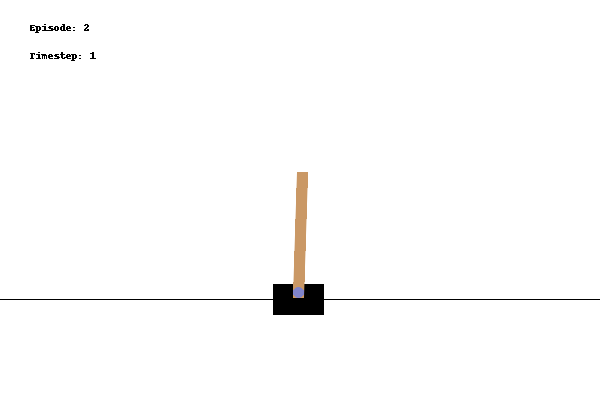

In [ ]:
from IPython import display
display.Image(open('/content/drive/MyDrive/Gif/DQN_agent.gif','rb').read())